**Config and setup**

---



In [0]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
from scipy.spatial import ConvexHull
from scipy.spatial import Delaunay
import os
import sys
import random
import math
import skimage.io
import time

In [0]:
!wget http://jacarini.dinf.usherbrooke.ca/static/dataset/baseline.zip
!wget http://jacarini.dinf.usherbrooke.ca/static/dataset/lowFramerate.zip
!wget http://jacarini.dinf.usherbrooke.ca/static/dataset/badWeather.zip
!wget http://jacarini.dinf.usherbrooke.ca/static/dataset/nightVideos.zip
!wget http://jacarini.dinf.usherbrooke.ca/static/dataset/shadow.zip
!wget http://jacarini.dinf.usherbrooke.ca/static/dataset/cameraJitter.zip



!yes | unzip -q baseline.zip 
!yes | unzip -q lowFramerate.zip
!yes | unzip -q badWeather.zip
!yes | unzip -q nightVideos.zip
!yes | unzip -q shadow.zip
!yes | unzip -q cameraJitter.zip

--2020-02-07 14:52:06--  http://jacarini.dinf.usherbrooke.ca/static/dataset/baseline.zip
Resolving jacarini.dinf.usherbrooke.ca (jacarini.dinf.usherbrooke.ca)... 132.210.238.218
Connecting to jacarini.dinf.usherbrooke.ca (jacarini.dinf.usherbrooke.ca)|132.210.238.218|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 287822607 (274M) [application/zip]
Saving to: ‘baseline.zip’

baseline.zip        100%[===================>] 274.49M  40.2MB/s    in 7.3s    

2020-02-07 14:52:14 (37.6 MB/s) - ‘baseline.zip’ saved [287822607/287822607]

--2020-02-07 14:52:15--  http://jacarini.dinf.usherbrooke.ca/static/dataset/lowFramerate.zip
Resolving jacarini.dinf.usherbrooke.ca (jacarini.dinf.usherbrooke.ca)... 132.210.238.218
Connecting to jacarini.dinf.usherbrooke.ca (jacarini.dinf.usherbrooke.ca)|132.210.238.218|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 330265267 (315M) [application/zip]
Saving to: ‘lowFramerate.zip’

lowFramerate.zip    100%[==

In [0]:
!git clone https://github.com/matterport/Mask_RCNN.git
!pip install mrcnn
!pip install git+https://github.com/philferriere/cocoapi.git#subdirectory=PythonAPI
!pip install pycocotools

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 111.84 MiB | 33.76 MiB/s, done.
Resolving deltas: 100% (569/569), done.
     |████████████████████████████████| 61kB 3.2MB/s 
  Created wheel for mrcnn: filename=mrcnn-0.2-cp36-none-any.whl size=54931 sha256=c0f6eb0dd054258480390d78785e6c5d6e575263aa2343b2b07a17a5fcaa4e49
  Stored in directory: /root/.cache/pip/wheels/11/ed/28/e550ddc897c04c336b923eae4eb35c9aae993d20ce39d9cc40
Successfully built mrcnn
  Cloning https://github.com/philferriere/cocoapi.git to /tmp/pip-req-build-vojts4p2
  Running command git clone -q https://github.com/philferriere/cocoapi.git /tmp/pip-req-build-vojts4p2
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-linux_x86_64.whl size=275411 sha256=df06edab372b27a366bcc5287d9e96369497d6ce2557e02c1578ffdab45362f6
  Stored in directory: /tmp/pip-ephem-wheel-cache-1pf1gb6q/wheels/69/

**Utils**

---



In [0]:
def fill(coordinates, myArray):  #ajoute des pixels blancs 
  for coordinate in coordinates :
    myArray[coordinate[0]][coordinate[1]] = 255


In [0]:
def binarize_integer(myInteger):  
  if myInteger>0:
    return 1
  return 0

binarize_array = np.vectorize(binarize_integer)

def DBScan(poi):
  resultingsROI = []
  while(len(poi) >= 4):
    firstElement = poi[0]
    poi.remove(firstElement)
    newROI = [firstElement]
    newElement = True
    lastElementChecked = 0
    while(newElement):
      newElement = False
      currentLength = len(newROI)
      for i in range(lastElementChecked, currentLength):
        eltToPop = []
        for j in range(len(poi)):
          if (np.linalg.norm(np.array(poi[j]) - np.array(newROI[i]))  <= 30): #on cherche les points proches
            newElement = True
            newROI.append(poi[j])
            eltToPop.append(j)
        k = 0
        for j in eltToPop:
          poi.pop(j - k)
          k+=1
            
      lastElementChecked = currentLength - 1
    if(len(newROI) >= 4):
      resultingsROI.append(newROI.copy())
  return resultingsROI

def build_mask(poi,shape):
  roi = DBScan(poi)
  mask = []
  for region in roi:
    if(len(region) > 3):
      try :
        hull = Delaunay(region, qhull_options = "QbB Qz")
        coordinates = np.array(np.meshgrid(np.arange(0,shape[0]),np.arange(0, shape[1]))).transpose([1,2,0])
        points = np.argwhere( hull.find_simplex( coordinates) >= 0 )
        mask.extend(points)
      except:
        ;
  return np.array(mask)

In [0]:
def get_mask_gt(path):
  img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
  _, binaryImg = cv2.threshold(img, 250, 255, cv2.THRESH_BINARY)
  mask = np.argwhere(binaryImg == 255)
  return mask

def get_mask_rcnn(masks, ids_to_detect):
  img_mask = []                                                  
  for j in range(len(masks[0]['class_ids'])):
    if(masks[0]['class_ids'][j] in ids_to_detect):
      img_mask.extend(np.argwhere(masks[0]['masks'][:, : ,j] == True))
  img_mask = np.array(img_mask)                                                                           
  return img_mask


**Metrics**

---



In [0]:
def accuracy(target,prediction, size):
  setMask1 = set([tuple(elt) for elt in target])
  setMask2 = set([tuple(elt) for elt in prediction])
  xor = len(setMask1^setMask2)
  return 1 - xor/size

def recall(target, prediction):
    setMask1 = set([tuple(elt) for elt in target])
    setMask2 = set([tuple(elt) for elt in prediction])
    if(len(setMask1) == 0):
      if(len(setMask2) == 0):
        return 1
      return 0
    return len(setMask1 & setMask2)/len(setMask1)
  
def IoU(mask1,mask2):
  setMask1 = set([tuple(elt) for elt in mask1])
  setMask2 = set([tuple(elt) for elt in mask2])
  inter = setMask1 & setMask2
  union = setMask1 | setMask2
  if(len(union)==0):
    return 1
  return len(inter)/len(union)


**Optical Flow**

---



In [0]:
def optical_flow(path1,path2):
  im1 = cv2.imread(path1, cv2.IMREAD_GRAYSCALE)
  im2 = cv2.imread(path2, cv2.IMREAD_GRAYSCALE)
  corners1 = cv2.goodFeaturesToTrack(im1, maxCorners = 2000, qualityLevel = 0.1, minDistance = 3, blockSize = 5 )
  corners2, st, err = cv2.calcOpticalFlowPyrLK(im1, im2, corners1, None, winSize  = (15,15), maxLevel = 0, 
                                       criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

  temp1 = np.int32(corners1)
  temp2 = np.int32(corners2)
  poi = []
  for j in range(0, len(corners2)):
    if(np.linalg.norm(np.array(corners1[j][0]) - np.array(corners2[j][0])) > 0.1): #la difference de couleur des coins depasse le seuil
      poi.append(corners1[j][0])
  masks = build_mask(poi, im1.shape)

  return masks


**Mask RCNN**

---

In [0]:
# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import pycocotools as coco


%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = 'MASK_RCNN/images'

In [0]:
from Mask_RCNN.samples.coco import coco
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()

In [0]:
# Create model object in inference mode.
rcnn_model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
rcnn_model.load_weights(COCO_MODEL_PATH, by_name=True)

In [0]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG','person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

In [0]:
# Load a random image from the images folder
def rcnn_detect(path):
  image = skimage.io.imread(path)

  # Run detection
  results = rcnn_model.detect([image], verbose=1)

  r = results
  return(r)


**Tests**

---

In [0]:
#visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])
def test_category(cat_name,frame_step=1):
  IMAGE_DIR = '/content/' + cat_name
  textFile = open(IMAGE_DIR+'temporalROI.txt', "r")
  framesNumbers = (textFile.read()).split(" ")
  textFile.close()
  firstFrame = int(framesNumbers[0])
  lastFrame = int(framesNumbers[1])
  nbframes = (lastFrame - firstFrame -1)//frame_step
  input_path = cat_name + 'input/*jpg'
  gt_path = cat_name + 'groundtruth/*png'
  input_paths = glob.glob(input_path)
  gt_paths = glob.glob(gt_path)
  input_paths.sort()
  gt_paths.sort()
  result_meth = {
    "exec_time" : np.zeros(nbframes),
    "accuracy" : np.zeros(nbframes),
    "recall" : np.zeros(nbframes),
    "iou" : np.zeros(nbframes),
 }

  result_meth2 = {
    "exec_time" : np.zeros(nbframes),
    "accuracy" : np.zeros(nbframes),
    "recall" : np.zeros(nbframes),
    "iou" : np.zeros(nbframes),
  }
  results = {
      "optical_flow" : dict(result_meth),
      "mask_rcnn" : dict(result_meth2),
  }
  
  id_car = class_names.index('car') 
  id_person = class_names.index('person') 
  id_truck = class_names.index('truck') 
  ids_to_detect = [id_car, id_truck, id_person]
  i=0
  im0 = cv2.imread(input_paths[0]).shape
  size = im0[0]*im0[1]
  for frame in range(firstFrame, lastFrame - 1, frame_step):
    
    start = time.time()
    mask_of = optical_flow(input_paths[frame],input_paths[frame+1])
    results["optical_flow"]["exec_time"][i] = time.time()-start
    start = time.time()
    result_rcnn = rcnn_detect(input_paths[frame])
    results["mask_rcnn"]["exec_time"][i] = time.time() - start
    mask_gt = get_mask_gt(gt_paths[frame])
    mask_rcnn = get_mask_rcnn(result_rcnn, ids_to_detect)
    results["optical_flow"]["accuracy"][i] = accuracy(mask_of,mask_gt,size)
    results["mask_rcnn"]["accuracy"][i] = accuracy(mask_rcnn,mask_gt,size)
    results["optical_flow"]["recall"][i] = recall(mask_of,mask_gt)
    results["mask_rcnn"]["recall"][i] = recall(mask_rcnn,mask_gt)
    results["optical_flow"]["iou"][i] = IoU(mask_of,mask_gt)
    results["mask_rcnn"]["iou"][i] = IoU(mask_rcnn,mask_gt)
    i = i+1
  return results

In [0]:
"""def print_results(metric,name):
  title = " "
  frames = np.arange(0,len(metric[0]),frame_step)
  fig, ax1 = plt.subplots()

  ax1.set_xlabel('frame')
  ax1.set_ylabel(name)
  line_loss = ax1.plot(frames, metric[0])
  ax1.tick_params(axis='y')
  ax1.legend(["flot optique"],loc="upper left")
  ax1.set_title(title)
  ax2 = ax1.twinx() 

  line_ac = ax2.plot(frames, metric[1],color='orange')
  ax2.tick_params(axis='y')
  ax2.legend(["RCNN"],loc="lower left")
  fig.tight_layout()
  plt.show()"""

In [0]:
def print_avg_results(results):
  print("Optical flow : average exec time : {}".format(np.average(results["optical_flow"]["exec_time"])))
  print("Optical flow : average accuracy : {}".format(np.average(results["optical_flow"]["accuracy"])))
  print("Optical flow : average recall : {}".format(np.average(results["optical_flow"]["recall"])))
  print("Optical flow : average IoU : {}".format(np.average(results["optical_flow"]["iou"])))
  print("Mask R-CNN : average exec time : {}".format(np.average(results["mask_rcnn"]["exec_time"])))
  print("Mask R-CNN : average accuracy : {}".format(np.average(results["mask_rcnn"]["accuracy"])))
  print("Mask R-CNN : average recall : {}".format(np.average(results["mask_rcnn"]["recall"])))
  print("Mask R-CNN : average IoU : {}".format(np.average(results["mask_rcnn"]["iou"])))

In [0]:
resultsbadWeather = test_category('badWeather/blizzard/')
print_avg_results(resultsbadWeather)

Output hidden; open in https://colab.research.google.com to view.

In [0]:
resultslowfps = test_category('lowFramerate/turnpike_0_5fps/')
print_avg_results(resultslowfps)

Processing 1 images
image                    shape: (240, 320, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Processing 1 images
image                    shape: (240, 320, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Processing 1 images
image                    shape: (240, 320, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.1

In [0]:
resultsshadow = test_category('shadow/busStation/')
print_avg_results(resultsshadow)

Processing 1 images
image                    shape: (240, 360, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  137.20000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Processing 1 images
image                    shape: (240, 360, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  137.20000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Processing 1 images
image                    shape: (240, 360, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  137.2

In [0]:
resultsnight = test_category('nightVideos/fluidHighway/')
print_avg_results(resultsnight)

Processing 1 images
image                    shape: (450, 700, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Processing 1 images
image                    shape: (450, 700, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Processing 1 images
image                    shape: (450, 700, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.1

In [0]:
resultsjitter = test_category('cameraJitter/traffic/')
print_avg_results(resultsjitter)

Processing 1 images
image                    shape: (240, 320, 3)         min:    8.00000  max:  233.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  114.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Processing 1 images
image                    shape: (240, 320, 3)         min:   12.00000  max:  253.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  139.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Processing 1 images
image                    shape: (240, 320, 3)         min:   11.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  144.1

In [0]:
resultsbaseline = test_category('baseline/highway/')
print_avg_results(resultsbaseline)

Processing 1 images
image                    shape: (240, 320, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  145.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Processing 1 images
image                    shape: (240, 320, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  145.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Processing 1 images
image                    shape: (240, 320, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  145.1

**Génération** **images** 


Processing 1 images
image                    shape: (240, 360, 3)         min:   34.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


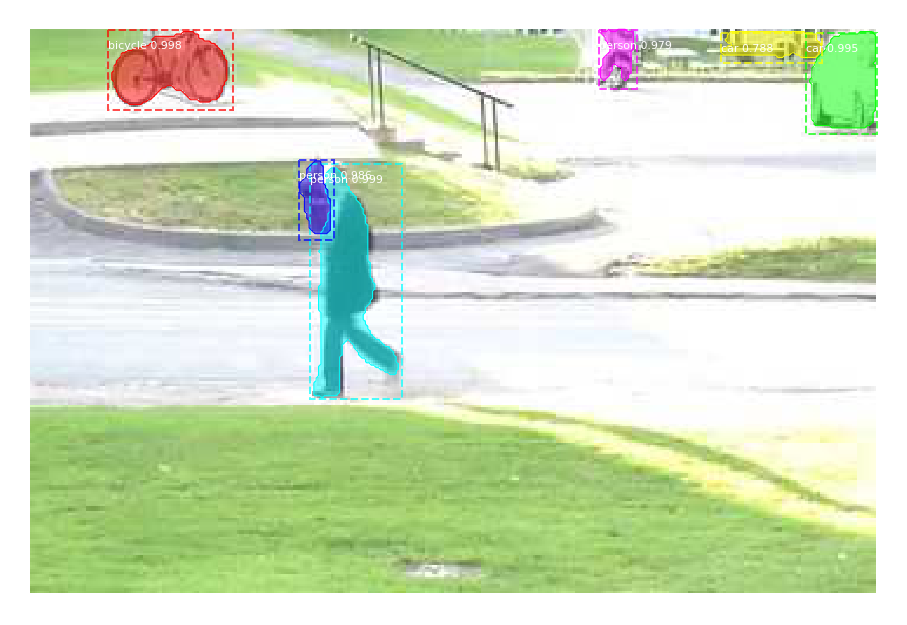

True

In [101]:
image = cv2.imread('/content/baseline/pedestrians/input/in000650.jpg', cv2.IMREAD_GRAYSCALE)

#Optical flow
image2 = cv2.imread('/content/baseline/pedestrians/input/in000651.jpg', cv2.IMREAD_GRAYSCALE)
corners1 = cv2.goodFeaturesToTrack(image, maxCorners = 2000, qualityLevel = 0.1, minDistance = 3, blockSize = 5 )
corners2, st, err = cv2.calcOpticalFlowPyrLK(image, image2, corners1, None, winSize  = (15,15), maxLevel = 0, 
                                       criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

temp1 = np.int32(corners1)
temp2 = np.int32(corners2)
poi = []
imageOF = np.copy(image)   
for j in range(0, len(corners2)):
  if(np.linalg.norm(np.array(corners1[j][0]) - np.array(corners2[j][0])) > 0.1): #la difference de couleur des coins depasse le seuil
    cv2.line(imageOF, (temp1[j,0,0],temp1[j,0,1]),(temp2[j,0,0],temp1[j,0,1]), 255, 2)
cv2.imwrite("/content/results/OF.jpg", imageOF)

masks = optical_flow('/content/baseline/pedestrians/input/in000650.jpg', '/content/baseline/pedestrians/input/in000651.jpg')
imageHull = np.zeros(image.shape)
fill(masks, imageHull)
cv2.imwrite("/content/results/hull.jpg", imageHull)

#Groundtruth
gt_mask = get_mask_gt('./baseline/pedestrians/groundtruth/gt000650.png')
imagegt = np.zeros(image.shape)
fill(gt_mask, imagegt)
cv2.imwrite("/content/results/gt.jpg", imagegt)
#Mask R-CNN
displayim = skimage.io.imread('./baseline/pedestrians/input/in000650.jpg')
results = rcnn_detect('./baseline/pedestrians/input/in000650.jpg')

# Visualize results
r = results[0]
visualize.display_instances(displayim, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

imagercnn = np.zeros(image.shape)
fill(get_mask_rcnn([r],[1]),imagercnn)
cv2.imwrite("/content/results/rcnn.jpg", imagercnn)

